<a href="https://colab.research.google.com/github/KajolY/data_science/blob/main/Extracting_Segments_Using_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

np.random.seed(1234)

data = pd.read_csv(r'https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv')

yes_no_cols = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']
data[yes_no_cols] = data[yes_no_cols].applymap(lambda x: 1 if x == 'Yes' else 0)

like_mapping = {'I love it!+5': 5, 'I hate it!-5': -5}
data['Like'] = data['Like'].replace(like_mapping)
data['Like'] = pd.to_numeric(data['Like'], errors='coerce')

label_encoders = {}
categorical_cols = ['VisitFrequency', 'Gender']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

MD_x = data.values



In [5]:
def perform_kmeans(data, k_range, n_init=10):
    kmeans_models = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=1234)
        kmeans.fit(data)
        kmeans_models[k] = kmeans
    return kmeans_models

k_range = range(2, 9)
kmeans_models = perform_kmeans(MD_x, k_range)


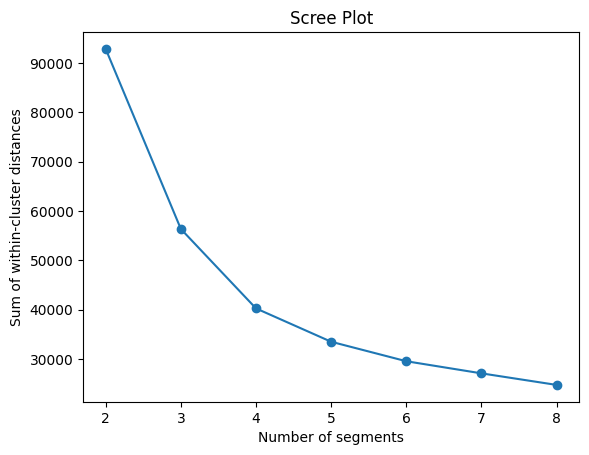

In [6]:
def plot_scree(kmeans_models):
    sum_of_distances = [model.inertia_ for model in kmeans_models.values()]
    plt.plot(list(kmeans_models.keys()), sum_of_distances, marker='o')
    plt.xlabel('Number of segments')
    plt.ylabel('Sum of within-cluster distances')
    plt.title('Scree Plot')
    plt.show()

plot_scree(kmeans_models)


In [7]:
from joblib import Parallel, delayed

def bootstrap_stability_parallel(data, k_range, n_boot=100, n_init=10):
    def run_bootstrap_sample(data, k_range, n_init):
        bootstrap_sample = resample(data)
        bootstrap_models = perform_kmeans(bootstrap_sample, k_range, n_init)

        stability = {k: [] for k in k_range}
        for k in k_range:
            labels1 = bootstrap_models[k].labels_
            labels2 = perform_kmeans(bootstrap_sample, [k], n_init)[k].labels_
            stability[k].append(adjusted_rand_score(labels1, labels2))

        return stability

    stabilities = Parallel(n_jobs=-1)(delayed(run_bootstrap_sample)(data, k_range, n_init) for _ in range(n_boot))

    stability = {k: [] for k in k_range}
    for s in stabilities:
        for k in k_range:
            stability[k].extend(s[k])

    return stability

# Usage:
stability_scores = bootstrap_stability_parallel(MD_x, k_range)


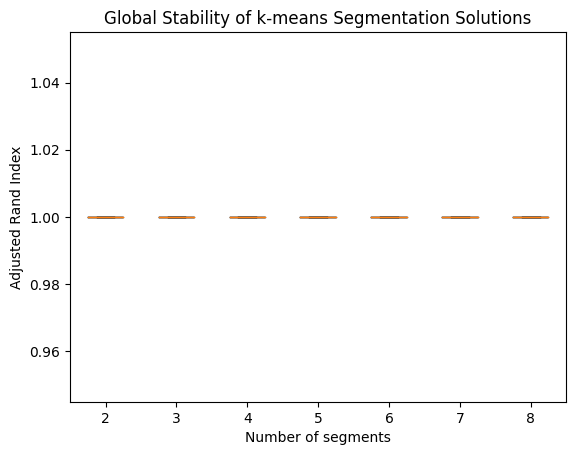

In [8]:
def plot_stability(stability_scores):
    fig, ax = plt.subplots()
    ax.boxplot([stability_scores[k] for k in k_range], labels=k_range)
    ax.set_xlabel('Number of segments')
    ax.set_ylabel('Adjusted Rand Index')
    ax.set_title('Global Stability of k-means Segmentation Solutions')
    plt.show()

plot_stability(stability_scores)


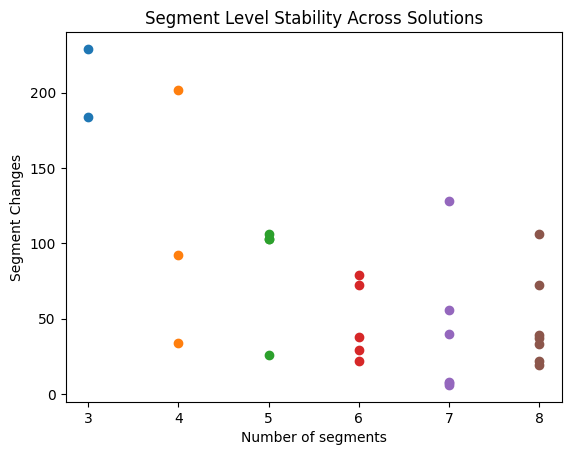

In [9]:
def segment_level_stability_across_solutions(kmeans_models, k_range):
    segment_changes = {k: [] for k in k_range[1:]}

    for i in range(len(k_range) - 1):
        k1 = k_range[i]
        k2 = k_range[i + 1]
        labels1 = kmeans_models[k1].labels_
        labels2 = kmeans_models[k2].labels_

        for segment in range(k1):
            changes = np.sum(labels1 == segment) - np.sum(labels2 == segment)
            segment_changes[k2].append(abs(changes))

    return segment_changes

segment_changes = segment_level_stability_across_solutions(kmeans_models, k_range)

def plot_segment_changes(segment_changes):
    fig, ax = plt.subplots()
    for k, changes in segment_changes.items():
        ax.plot([k] * len(changes), changes, 'o')
    ax.set_xlabel('Number of segments')
    ax.set_ylabel('Segment Changes')
    ax.set_title('Segment Level Stability Across Solutions')
    plt.show()

plot_segment_changes(segment_changes)


In [10]:
# Selecting the four-segment solution based on stability analysis
optimal_k = 4
MD_k4 = kmeans_models[optimal_k]

# Save the segment labels to a CSV file
output_data = pd.DataFrame(MD_k4.labels_, columns=['Segment'])
output_data.to_csv('segmentation_results.csv', index=False)
